# **15.456 - Final Proejct**

## **1 - Volatility Models**

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm

In [4]:
# Classic GBM
def GBM(S0, mu, sigma, T, dt):
    N = int(T / dt)
    t = np.linspace(0, T, N + 1)
    W = np.random.normal(0, np.sqrt(dt), N + 1)
    W[0] = 0
    W = np.cumsum(W)
    S = S0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * W)
    return S, t

### *1.1 - Time-varying Vol*

In [5]:
# # Linear increasing/decreasing volatility
# def sigma_linear(t, sigma0=0.2, sigma1=0.4):
#     return sigma0 + (sigma1 - sigma0) * t

# # Seasonal/cyclical volatility
# def sigma_seasonal(t, sigma0=0.2, amplitude=0.1, period=1.0):
#     return sigma0 + amplitude * np.sin(2 * np.pi * t / period)

# # Step function volatility
# def sigma_stepwise(t, sigma0=0.2, sigma1=0.4, change_point=0.5):
#     return np.where(t < change_point, sigma0, sigma1)

In [6]:
# Linear volatility
def sigma_linear(t, sigma0=0.2, sigma1=0.4, sigma2=0.1, num_changes=2, change_points=None):
    if change_points is None:
        change_points = np.sort(np.random.uniform(0, 1, num_changes))
    conditions = [t < change_points[0]]
    values = [sigma0 + (sigma1 - sigma0) * (t / change_points[0])]
    for i in range(1, len(change_points)):
        conditions.append((t >= change_points[i-1]) & (t < change_points[i]))
        next_sigma = sigma2 if i == len(change_points) - 1 else sigma1
        values.append(next_sigma + (sigma2 - next_sigma) * ((t - change_points[i-1]) / (change_points[i] - change_points[i-1])))
    conditions.append(t >= change_points[-1])
    values.append(sigma2 + (sigma0 - sigma2) * ((t - change_points[-1]) / (1 - change_points[-1])))
    return np.select(conditions, values)

# Seasonal volatility
def sigma_seasonal(t, sigma0=0.2, amplitude=0.1, period=1.0, cycles=None):
    if cycles is None:
        cycles = np.random.poisson(2) + 1  # Ensure nonzero cycle count
    return sigma0 + amplitude * np.sin(2 * np.pi * cycles * t / period)

# Stepwise volatility
def sigma_stepwise(t, sigmas=[0.2, 0.4], num_changes=2, change_points=None):
    if change_points is None:
        change_points = np.sort(np.random.uniform(0, 1, num_changes))
    conditions = [t < change_points[0]]
    values = [sigmas[0]]
    for i in range(1, len(change_points)):
        conditions.append((t >= change_points[i-1]) & (t < change_points[i]))
        values.append(sigmas[i % len(sigmas)])
    conditions.append(t >= change_points[-1])
    values.append(sigmas[len(change_points) % len(sigmas)])
    return np.select(conditions, values)

In [7]:
# GBM with time-varying volatility
def GBM_timevarying(S0, mu, sigma_func, T, dt, *args, **kwargs):
    N = int(T / dt)
    t = np.linspace(0, T, N+1)
    sigma_t = sigma_func(t[:-1], *args, **kwargs)  # Forwarding additional parameters
    W = np.random.normal(0, np.sqrt(dt), N)
    W = np.insert(W, 0, 0)
    W_cum = np.cumsum(W)

    drift = (mu - 0.5 * sigma_t**2) * dt
    diffusion = sigma_t * W[1:]

    drift = np.insert(np.cumsum(drift), 0, 0)
    diffusion = np.insert(np.cumsum(diffusion), 0, 0)

    S = S0 * np.exp(drift + diffusion)
    return S, t

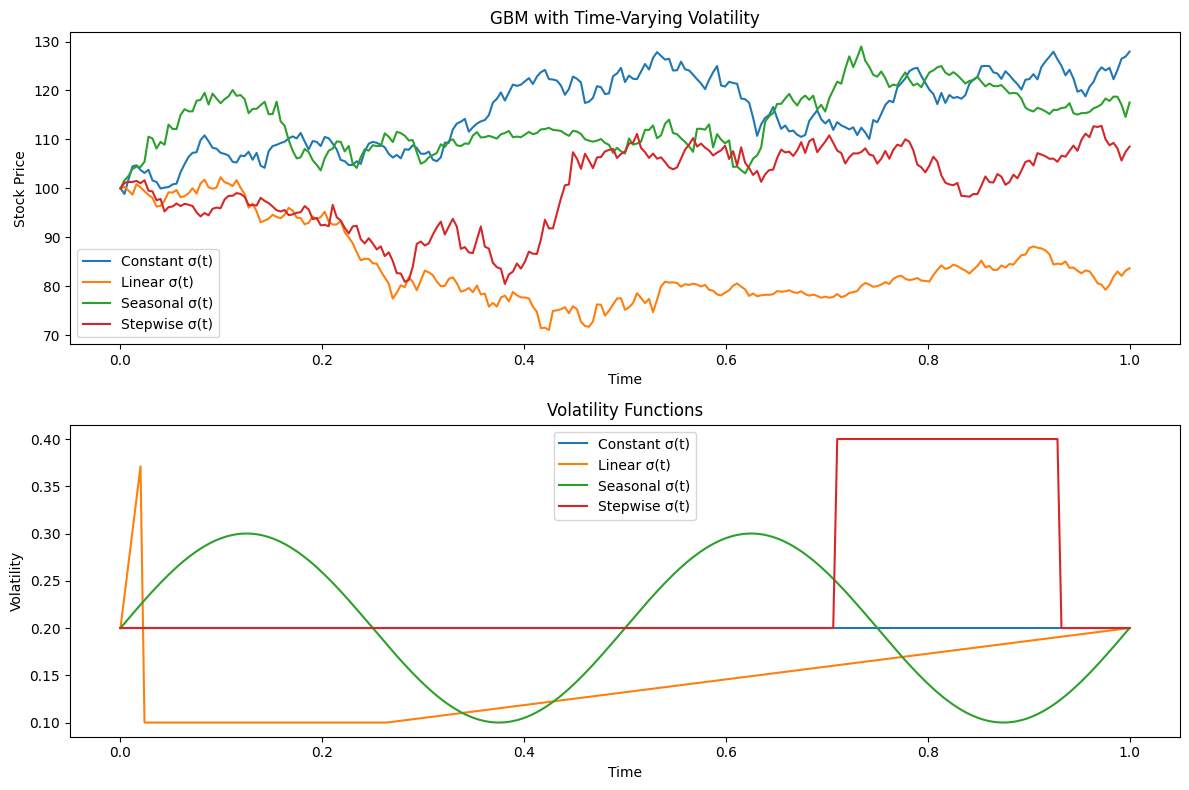

In [8]:
# Simulation setup
S0 = 100
mu = 0.08
T = 1.0
dt = 1/252
sigma = 0.2 # Constant volatility

# Parameters for volatility functions
num_changes_linear = 2
num_cycles_seasonal = 2
num_changes_stepwise = 2

# Generate paths
S_constant, t = GBM(S0, mu, sigma, T, dt)
S_linear, _ = GBM_timevarying(S0, mu, sigma_linear, T, dt, num_changes=num_changes_linear)
S_seasonal, _ = GBM_timevarying(S0, mu, sigma_seasonal, T, dt, cycles=num_cycles_seasonal)
S_stepwise, _ = GBM_timevarying(S0, mu, sigma_stepwise, T, dt, num_changes=num_changes_stepwise)

# Plotting
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(t, S_constant, label='Constant σ(t)')
plt.plot(t, S_linear, label='Linear σ(t)')
plt.plot(t, S_seasonal, label='Seasonal σ(t)')
plt.plot(t, S_stepwise, label='Stepwise σ(t)')
plt.title('GBM with Time-Varying Volatility')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t, np.array([sigma] * len(t)), label='Constant σ(t)')
plt.plot(t, sigma_linear(t, num_changes=num_changes_linear), label='Linear σ(t)')
plt.plot(t, sigma_seasonal(t, cycles=num_cycles_seasonal), label='Seasonal σ(t)')
plt.plot(t, sigma_stepwise(t, num_changes=num_changes_stepwise), label='Stepwise σ(t)')
plt.title('Volatility Functions')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()

plt.tight_layout()
plt.show()

### *1.2 - Heston Model Vol*

In [9]:
def heston_model(S0, sigma0, mu, lambda_, sigmabar, xi, rho, T, dt):
    N = int(T/dt)
    t = np.linspace(0, T, N+1)
    S = np.zeros(N+1)
    variance = np.zeros(N+1)
    S[0] = S0
    variance[0] = sigma0**2

    dW_S = np.random.normal(0, np.sqrt(dt), N)
    dW_variance = np.random.normal(0, np.sqrt(dt), N)
    dW_variance = rho * dW_S + np.sqrt(1 - rho**2) * dW_variance

    for i in range(1, N+1):
        variance[i] = variance[i-1] + lambda_ * (sigmabar**2 - variance[i-1]) * dt + xi * np.sqrt(max(variance[i-1], 0)) * dW_variance[i-1]
        S[i] = S[i-1] + mu * S[i-1] * dt + np.sqrt(max(variance[i-1], 0)) * S[i-1] * dW_S[i-1]

    return S, np.sqrt(variance), t

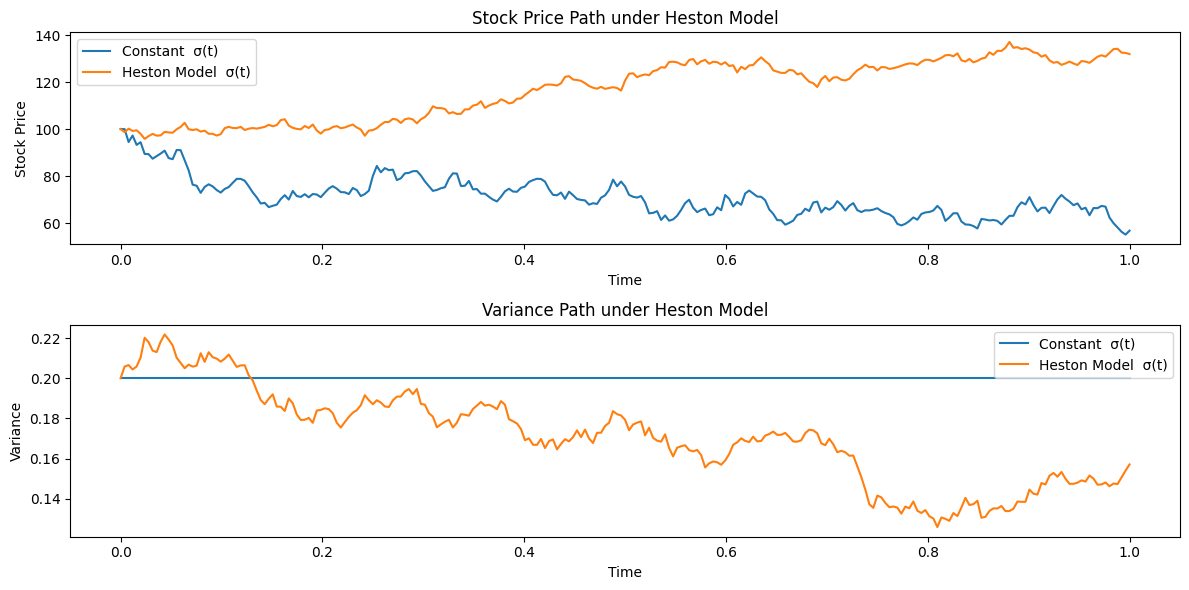

In [10]:
# Model parameters
S0 = 100
sigma0 = 0.2        # Initial vol
mu = 0.08
lambda_ = 0.2       # Mean reversion rate
sigmabar = 0.2      # Long-term vol
xi = 0.1            # Volatility of vol
rho = -0.2          # Stock-vol correlation
T = 1.0
dt = 1/252

# Generate paths
S_heston, variance, t = heston_model(S0, sigma0, mu, lambda_, sigmabar, xi, rho, T, dt)
S_constant, _ = GBM(S0, mu, np.sqrt(sigmabar), T, dt)

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, S_constant, label='Constant  σ(t)')
plt.plot(t, S_heston, label='Heston Model  σ(t)')
plt.title('Stock Price Path under Heston Model')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t, sigmabar * np.ones(len(t)), label='Constant  σ(t)')
plt.plot(t, variance, label='Heston Model  σ(t)')
plt.title('Variance Path under Heston Model')
plt.xlabel('Time')
plt.ylabel('Variance')
plt.legend()
plt.tight_layout()
plt.show()

### *1.3 - GARCH(1,1) Vol*

In [11]:
def garch_volatility(N, sigma0, kappa, sigma_bar, alpha, z):
    """ Generate GARCH(1,1) volatility path using N+1 points including the starting point. """
    sigma2 = np.zeros(N+1)
    sigma2[0] = sigma0**2

    for i in range(1, N+1):
        sigma2[i] = kappa * sigma_bar**2 + (1 - kappa - alpha) * sigma2[i-1] + alpha * z[i-1]**2 * sigma2[i-1]

    return np.sqrt(sigma2)

def GBM_garch(S0, mu, sigma0, kappa, sigma_bar, alpha, T, dt):
    N = int(T / dt)
    t = np.linspace(0, T, N+1)
    S = np.zeros(N+1)
    S[0] = S0
    z = np.random.normal(0, 1, N)
    sigma_t = garch_volatility(N, sigma0, kappa, sigma_bar, alpha, z)

    dW = np.random.normal(0, np.sqrt(dt), N)

    for i in range(1, N+1):
        S[i] = S[i-1] * np.exp((mu - 0.5 * sigma_t[i-1]**2) * dt + sigma_t[i-1] * dW[i-1])

    return S, sigma_t, t

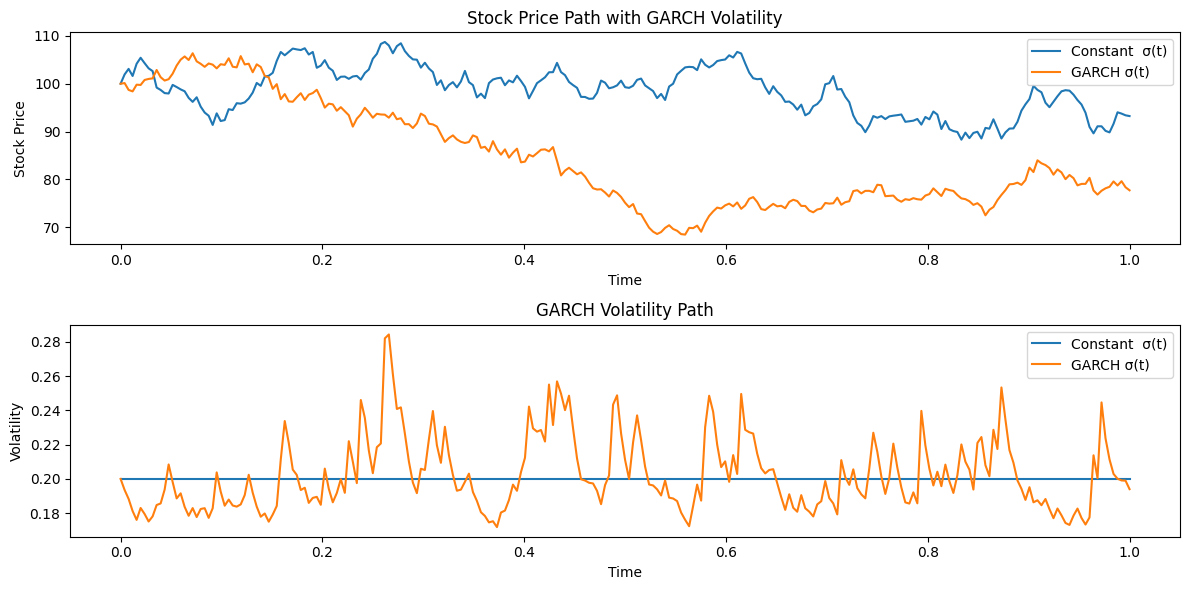

In [12]:
S0 = 100
mu = 0.08
sigma0 = 0.2       # Initial vol
kappa = 0.2        # Mean reversion coefficient
sigma_bar = 0.2    # Long term vol
alpha = 0.1        # GARCH reaction coefficient
T = 1.0
dt = 1/252

# Generate paths
S_garch, sigma_garch, t = GBM_garch(S0, mu, sigma0, kappa, sigma_bar, alpha, T, dt)
S_constant, _ = GBM(S0, mu, sigma_bar, T, dt)

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, S_constant, label='Constant  σ(t)')
plt.plot(t, S_garch, label='GARCH σ(t)')
plt.title('Stock Price Path with GARCH Volatility')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t, sigmabar * np.ones(len(t)), label='Constant  σ(t)')
plt.plot(t, sigma_garch, label='GARCH σ(t)')
plt.title('GARCH Volatility Path')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()

plt.tight_layout()
plt.show()

## **2 - Return Distributions** [WE SHOULD PLAY AROUND WITH EACH MODEL'S PARAMS]

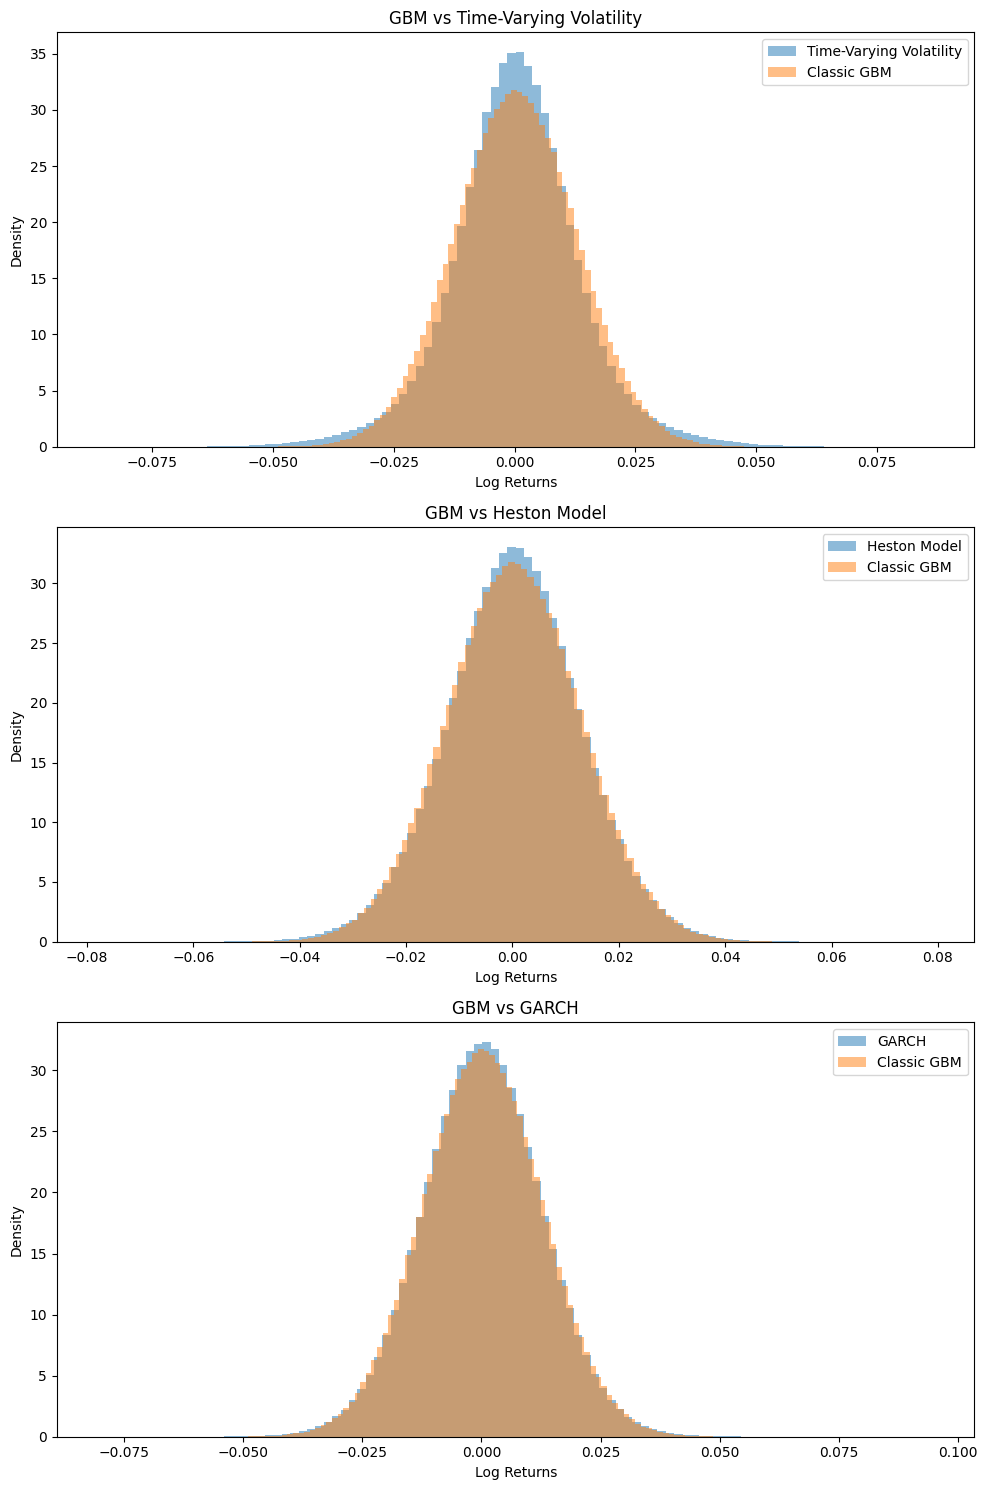

In [ ]:
# Log returns calculator
def log_ret(S):
    return np.log(S[1:] / S[:-1])

# Monte Carlo simulation function
def monte_carlo_simulation(S0, mu, sigma, T, dt, num_paths, model, **kwargs):
    N = int(T / dt)
    all_S = np.zeros((num_paths, N + 1))
    all_log_returns = np.zeros((num_paths, N))

    for i in range(num_paths):
        if model == 'classic_gbm':
            S, _ = GBM(S0, mu, sigma, T, dt)
        elif model == 'garch':
            S, _, _ = GBM_garch(S0, mu, kwargs['sigma0'], kwargs['kappa'], kwargs['sigma_bar'], kwargs['alpha'], T, dt)
        elif model == 'time_varying':
            S, _ = GBM_timevarying(S0, mu, kwargs['sigma_func'], T, dt, **kwargs['sigma_func_params'])
        elif model == 'garch_jump':
            S, _, _ = GBM_garch_jump(S0, mu, kwargs['sigma0'], kwargs['kappa'], kwargs['sigma_bar'], kwargs['alpha'], kwargs['lambda_j'], kwargs['mu_j'], kwargs['sigma_j'], T, dt)
        elif model == 'heston':
            S, _, _ = heston_model(S0, kwargs['sigma0'], mu, kwargs['lambda_'], kwargs['sigmabar'], kwargs['xi'], kwargs['rho'], T, dt)
        
        all_S[i] = S
        all_log_returns[i] = log_ret(S)

    return all_log_returns

# General parameters
num_paths = 5000
S0 = 100                        # Initial stock price for all models
mu = 0.08                       # Drift rate for all models
T = 1.0                         # Total time for all models
dt = 1/252                      # Time step

# Classic GBM parameters
sigma_constant = 0.2            # Constant vol

# Time-varying volatility (Stepwise func) parameters
num_jumps = 2                   # Number of jumps
low_vol = 0.15                  # Low volatility
high_vol = 0.3                  # High volatility

# Heston model parameters
lambda_heston = 0.25             # Mean reversion rate
sigmabar_heston = 0.2           # Long-term volatility
xi_heston = 0.1                 # Volatility of vol
rho_heston = -0.6               # Correlation between stock and variance

# GARCH model parameters
kappa_garch = 0.2               # Mean reversion coefficient
sigma_bar_garch = 0.2           # Long term volatility
alpha_garch = 0.13              # Reaction coefficient

# Monte Carlo simulations
log_returns_constant = monte_carlo_simulation(S0, mu, sigma_constant, T, dt, num_paths, 'classic_gbm')
log_returns_garch = monte_carlo_simulation(S0, mu, sigma_constant, T, dt, num_paths, 'garch', sigma0=sigma0, kappa=kappa_garch, sigma_bar=sigma_bar_garch, alpha=alpha_garch)
log_returns_time_varying = monte_carlo_simulation(S0, mu, sigma_constant, T, dt, num_paths, 'time_varying', sigma_func=sigma_stepwise, sigma_func_params={'num_changes': num_jumps, 'sigmas': [low_vol, high_vol]})
log_returns_heston = monte_carlo_simulation(S0, mu, sigma_constant, T, dt, num_paths, 'heston', sigma0=sigma0, lambda_=lambda_heston, sigmabar=sigmabar_heston, xi=xi_heston, rho=rho_heston)

# Plotting histograms of log returns for each model
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Time-Varying vs GBM
axs[0].hist(log_returns_time_varying.flatten(), bins=100, alpha=0.5, label='Time-Varying Volatility', density=True)
axs[0].hist(log_returns_constant.flatten(), bins=100, alpha=0.5, label='Classic GBM', density=True)
axs[0].set_title('GBM vs Time-Varying Volatility')
axs[0].set_xlabel('Log Returns')
axs[0].set_ylabel('Density')
axs[0].legend()

# Heston vs GBM
axs[1].hist(log_returns_heston.flatten(), bins=100, alpha=0.5, label='Heston Model', density=True)
axs[1].hist(log_returns_constant.flatten(), bins=100, alpha=0.5, label='Classic GBM', density=True)
axs[1].set_title('GBM vs Heston Model')
axs[1].set_xlabel('Log Returns')
axs[1].set_ylabel('Density')
axs[1].legend()

# GARCH vs GBM
axs[2].hist(log_returns_garch.flatten(), bins=100, alpha=0.5, label='GARCH', density=True)
axs[2].hist(log_returns_constant.flatten(), bins=100, alpha=0.5, label='Classic GBM', density=True)
axs[2].set_title('GBM vs GARCH')
axs[2].set_xlabel('Log Returns')
axs[2].set_ylabel('Density')
axs[2].legend()

plt.tight_layout()
plt.show()

## 3 - Fitting to Empirical Data

In [ ]:
import wrds
import pandas as pd

### !!! Do not re-run if you don't have access to WRDS

db = wrds.Connection()

# Query S&P 500 daily returns
sp500_data = db.raw_sql("""
    SELECT
        caldt AS date,
        vwretd AS ret
    FROM
        crsp.dsp500
    WHERE
        caldt BETWEEN '2000-01-01' AND '2020-12-31'
    ORDER BY
        caldt;
""")

# Calculate log returns
sp500_data['log_ret'] = np.log(1 + sp500_data['ret'])

# Align the index excluding first row
# sp500_data = sp500_data.iloc[1:].copy()
# sp500_data['log_ret'] = log_returns

sp500_data.dropna(inplace=True)

sp500_data.to_csv('sp500_data.csv', index=False)

# Load S&P 500 data
sp500_data = pd.read_csv('sp500_data.csv')

WRDS recommends setting up a .pgpass file.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [ ]:
sp500_log_ret = sp500_data['log_ret'].values

# GARCH likelihood function
def garch_ll(params, returns, burn_in=100):
    kappa, alpha, sigma_bar = params
    T = len(returns)
    daily_returns = returns
    
    # Initialize variance (annualized)
    sigma2 = np.zeros(T)
    sigma2[0] = np.var(daily_returns) * 252 
    
    for t in range(1, T):
        # sigma_bar is already annualized, but returns are daily
        sigma2[t] = kappa * sigma_bar**2 + (1 - kappa - alpha) * sigma2[t-1] + alpha * (252 * daily_returns[t-1]**2)
    
    # Convert variances to daily scale for likelihood computation
    daily_sigma2 = sigma2 / 252
    
    # Log-likelihood (using daily scale)
    ll = -0.5 * (np.log(2*np.pi) + np.log(daily_sigma2[burn_in:]) + 
                 daily_returns[burn_in:]**2/daily_sigma2[burn_in:])
    return -np.sum(ll)

def fit_garch(returns, burn_in=100):
    # Initial guesses (annualized)
    initial_params = [0.2, 0.1, 0.2]  # [kappa, alpha, sigma_bar]
    
    # Constraints: 1 - kappa - alpha > 0 for stationarity
    constraints = ({'type': 'ineq', 'fun': lambda x: 1 - x[0] - x[1]})
    
    # Bounds for parameters
    bounds = [(1e-6, 0.999), (1e-6, 0.999), (1e-6, None)]  # kappa, alpha, sigma_bar
    
    result = minimize(garch_ll, 
                     initial_params,
                     args=(returns, burn_in),
                     method='SLSQP',
                     bounds=bounds,
                     constraints=constraints)
    
    if not result.success:
        raise RuntimeError(f"GARCH fitting failed: {result.message}")
    
    return result.x

def fit_gbm(log_returns):
    mu = np.mean(log_returns) * 252  # Annualize the mean
    sigma = np.std(log_returns) * np.sqrt(252)  # Annualize the standard deviation
    return mu, sigma

params = fit_garch(sp500_log_ret)
print("Fitted GARCH parameters: alpha, kappa, sigma_bar =", params)

mu_gbm, sigma_gbm = fit_gbm(sp500_log_ret)
print("Fitted GBM parameters: mu =", mu_gbm, "sigma =", sigma_gbm)

Fitted GARCH parameters: alpha, kappa, sigma_bar = [0.01746599 0.12083713 0.18191833]
Fitted GBM parameters: mu = 0.06466246215654853 sigma = 0.19866332992677585


GBM returns range: -0.06332937847056692 0.06458770021333997
GARCH returns range: -0.05895862122509627 0.058369359840688695


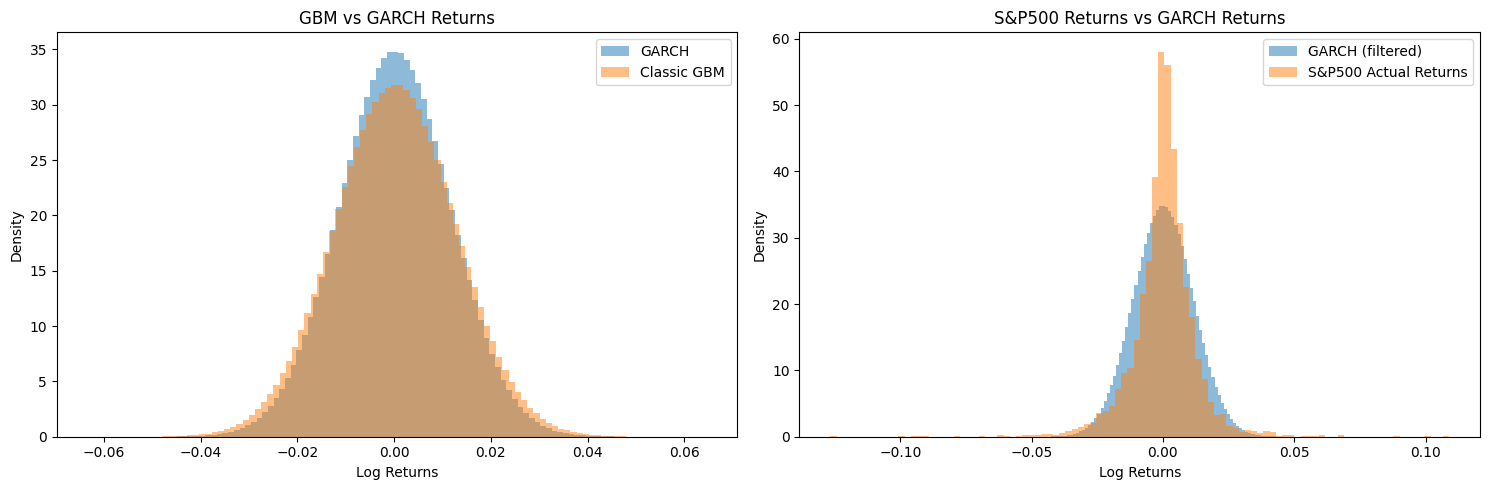

In [ ]:
# General parameters
num_paths = 20000
S0 = 100                        
mu = mu_gbm                     
T = 1.0                         
dt = 1/252                      

# Classic GBM parameters
sigma_constant = sigma_gbm      

# GARCH model parameters
kappa_garch = params[1]         
sigma_bar_garch = params[2]     
alpha_garch = params[0]         

# For initial volatility, use long-term volatility
sigma0 = sigma_bar_garch

# Monte Carlo simulations
log_returns_constant = monte_carlo_simulation(S0, mu, sigma_constant, T, dt, num_paths, 'classic_gbm')
log_returns_garch = monte_carlo_simulation(S0, mu, sigma0, T, dt, num_paths, 'garch', 
                                         sigma0=sigma0, 
                                         kappa=kappa_garch, 
                                         sigma_bar=sigma_bar_garch, 
                                         alpha=alpha_garch)

# Ranges
print("GBM returns range:", np.min(log_returns_constant), np.max(log_returns_constant))
print("GARCH returns range:", np.min(log_returns_garch), np.max(log_returns_garch))

# Plot against GBM and S&P 500 returns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Raw data
ax1.hist(log_returns_garch.flatten(), bins=100, alpha=0.5, label='GARCH', density=True)
ax1.hist(log_returns_constant.flatten(), bins=100, alpha=0.5, label='Classic GBM', density=True)
ax1.set_title('GBM vs GARCH Returns')
ax1.set_xlabel('Log Returns')
ax1.set_ylabel('Density')
ax1.legend()

# Filtered data
ax2.hist(log_returns_garch.flatten(), bins=100, alpha=0.5, label='GARCH', density=True)
ax2.hist(sp500_log_ret.flatten(), bins=100, alpha=0.5, label='S&P500 Actual Returns', density=True)
ax2.set_title('S&P500 Returns vs GARCH Returns')
ax2.set_xlabel('Log Returns')
ax2.set_ylabel('Density')
ax2.legend()

plt.tight_layout()
plt.show()

## 4.0 - GARCH(1,1)-JumpDiffusion Model

In [ ]:
def sigma_garch_jump(N, sigma0, kappa, sigma_bar, alpha, z):
    sigma2 = np.zeros(N+1)
    sigma2[0] = sigma0**2
    
    for i in range(1, N+1):
        sigma2[i] = kappa * sigma_bar**2 + (1 - kappa - alpha) * sigma2[i-1] + alpha * z[i-1]**2 * sigma2[i-1]
    
    return np.sqrt(sigma2)

def GBM_garch_jump(S0, mu, sigma0, kappa, sigma_bar, alpha, lambda_j, mu_j, sigma_j, T, dt):
    N = int(T / dt)
    t = np.linspace(0, T, N+1)
    S = np.zeros(N+1)
    S[0] = S0
    
    # Generate standard normal variables for GARCH
    z = np.random.normal(0, 1, N)
    
    # Get GARCH volatility path
    sigma_t = sigma_garch_jump(N, sigma0, kappa, sigma_bar, alpha, z)
    
    # Generate Brownian increments
    dW = np.random.normal(0, np.sqrt(dt), N)
    
    # Generate jump process
    n_jumps = np.random.poisson(lambda_j * dt, N)
    jump_sizes = np.random.normal(mu_j * dt, sigma_j * np.sqrt(dt), N) * n_jumps
    
    # Simulate price path
    for i in range(1, N+1):
        diffusion = (mu - 0.5 * sigma_t[i-1]**2) * dt + sigma_t[i-1] * dW[i-1]
        S[i] = S[i-1] * np.exp(diffusion + jump_sizes[i-1])
    
    return S, sigma_t, t

Initial parameters satisfy constraints: True

Fitted GARCH-Jump parameters:
kappa: 0.2000
alpha: 0.1000
sigma_bar: 0.1975
lambda_j: 4.6737 (jumps per year)
mu_j: -0.0098
sigma_j: 0.0328
Final parameters satisfy constraints: True


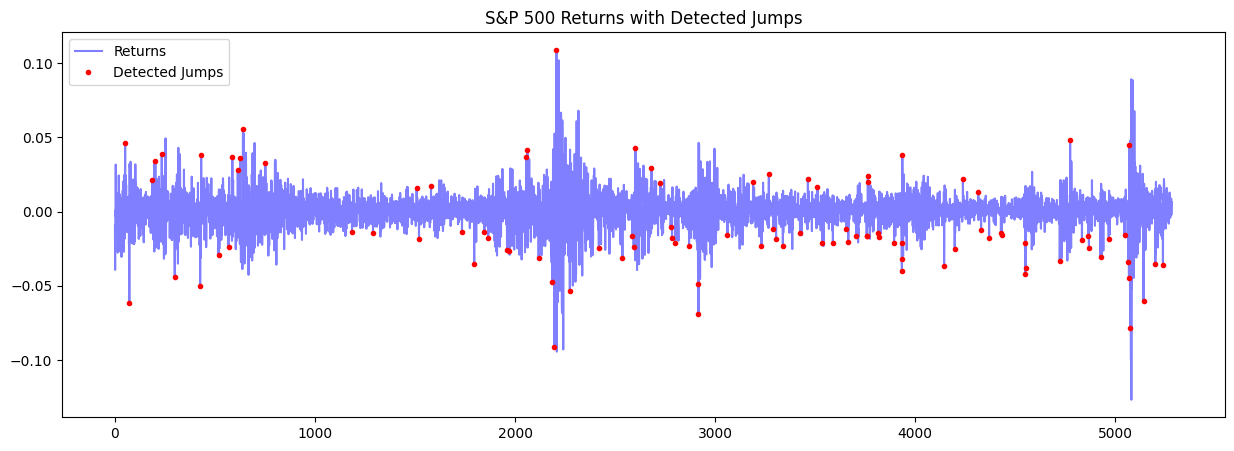

In [ ]:
import numpy as np
from scipy.stats import norm, kstest
from scipy.optimize import minimize
from scipy import signal

# Detect jumps using a rolling window approach and local volatility
def detect_jumps(returns, window=21, threshold=3):
    rolling_std = np.zeros_like(returns)
    rolling_mean = np.zeros_like(returns)
    
    # Calculate rolling statistics
    for i in range(window, len(returns)):
        window_returns = returns[i-window:i]
        rolling_std[i] = np.std(window_returns)
        rolling_mean[i] = np.mean(window_returns)
    
    rolling_std[:window] = rolling_std[window]
    rolling_mean[:window] = rolling_mean[window]
    
    # Detect jumps
    jumps = np.abs(returns - rolling_mean) > threshold * rolling_std
    jump_sizes = returns[jumps]
    jump_times = np.where(jumps)[0]
    
    # Estimate jump parameters
    if len(jump_sizes) > 0:
        lambda_j = len(jump_sizes) / (len(returns) / 252)  # annualized jump frequency
        mu_j = np.mean(jump_sizes)
        sigma_j = np.std(jump_sizes)
    else:
        lambda_j, mu_j, sigma_j = 0, 0, 0
        
    return lambda_j, mu_j, sigma_j, jumps, jump_sizes, jump_times

# Estimate diffusion parameters after removing jumps
def estimate_diffusion_parameters(returns, jumps):
    # Create copy of returns without jumps
    filtered_returns = returns.copy()
    filtered_returns[jumps] = np.nan
    
    # Interpolate missing values
    mask = np.isnan(filtered_returns)
    filtered_returns[mask] = np.interp(
        np.flatnonzero(mask), 
        np.flatnonzero(~mask), 
        filtered_returns[~mask]
    )
    
    return filtered_returns

# Helper to check if parameters satisfy constraints
def check_constraints(params):
    kappa, alpha = params[:2]
    lambda_j = params[3]
    return (1 - kappa - alpha > 0) and (lambda_j > 0)


def garch_jump_ll(params, returns, jumps, jump_times):
    kappa, alpha, sigma_bar, lambda_j, mu_j, sigma_j = params
    T = len(returns)
    
    # Generate z for volatility calculation
    z = np.random.normal(0, 1, T-1)
    
    # Get volatility path
    sigma_t = sigma_garch_jump(T-1, np.sqrt(np.var(returns) * 252), 
                                  kappa, sigma_bar, alpha, z)
    
    log_likelihood = 0
    
    for t in range(1, T):
        daily_sigma2 = sigma_t[t-1]**2
        
        if jumps[t]:
            total_var = daily_sigma2 + sigma_j**2
            density = norm.pdf(returns[t], mu_j, np.sqrt(total_var))
            log_likelihood += np.log(max(1e-10, density * lambda_j/252))
        else:
            density = norm.pdf(returns[t], 0, np.sqrt(daily_sigma2))
            log_likelihood += np.log(max(1e-10, density * (1 - lambda_j/252)))
    
    return -log_likelihood

def fit_garch_jump(returns, window=21, threshold=3):
    # Detect jumps
    lambda_j, mu_j, sigma_j, jumps, jump_sizes, jump_times = detect_jumps(
        returns, window, threshold
    )
    
    # Get filtered returns
    filtered_returns = estimate_diffusion_parameters(returns, jumps)
    
    # Fit GARCH to filtered returns
    initial_garch = fit_garch(filtered_returns)
    kappa_init, alpha_init, sigma_bar_init = initial_garch
    
    # Ensure initial parameters satisfy constraints
    if kappa_init + alpha_init >= 1:
        kappa_init = 0.2
        alpha_init = 0.1
    
    # Joint optimization with good starting values
    initial_params = [
        kappa_init, alpha_init, sigma_bar_init,
        max(1e-6, lambda_j), mu_j, max(1e-6, sigma_j)
    ]
    
    print("Initial parameters satisfy constraints:", check_constraints(initial_params))
    
    constraints = [
        {'type': 'ineq', 'fun': lambda x: 1 - x[0] - x[1] - 1e-6},  # GARCH stationarity
        {'type': 'ineq', 'fun': lambda x: x[3] - 1e-6}  # positive jump intensity
    ]
    
    bounds = [
        (1e-6, 0.99),     # kappa
        (1e-6, 0.99),     # alpha
        (1e-6, 1.0),     # sigma_bar
        (1e-6, 252.0),   # lambda_j
        (-0.5, 0.5),     # mu_j
        (1e-6, 0.5)      # sigma_j
    ]
    
    # Multiple optimization methods attempts
    methods = ['SLSQP', 'trust-constr']
    best_result = None
    best_value = float('inf')
    
    for method in methods:
        try:
            result = minimize(
                garch_jump_ll,
                initial_params,
                args=(returns, jumps, jump_times),
                method=method,
                bounds=bounds,
                constraints=constraints,
                options={'maxiter': 1000, 'ftol': 1e-8}
            )
            
            if result.success and result.fun < best_value:
                best_result = result
                best_value = result.fun
        except:
            continue
    
    if best_result is None or not check_constraints(best_result.x):
        # If optimization fails, return conservative estimates
        return [0.2, 0.1, sigma_bar_init, lambda_j, mu_j, sigma_j], jumps, jump_times
    
    return best_result.x, jumps, jump_times

# Usage:
params_jump, detected_jumps, jump_times = fit_garch_jump(sp500_log_ret)
kappa, alpha, sigma_bar, lambda_j, mu_j, sigma_j = params_jump

print("\nFitted GARCH-Jump parameters:")
print(f"kappa: {kappa:.4f}")
print(f"alpha: {alpha:.4f}")
print(f"sigma_bar: {sigma_bar:.4f}")
print(f"lambda_j: {lambda_j:.4f} (jumps per year)")
print(f"mu_j: {mu_j:.4f}")
print(f"sigma_j: {sigma_j:.4f}")
print(f"Final parameters satisfy constraints: {check_constraints(params_jump)}")

# Optional: Plot the detected jumps
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(sp500_log_ret, 'b-', alpha=0.5, label='Returns')
plt.plot(np.where(detected_jumps)[0], sp500_log_ret[detected_jumps], 
         'r.', label='Detected Jumps')
plt.title('S&P 500 Returns with Detected Jumps')
plt.legend()
plt.show()


Summary Statistics:
GBM returns range: -0.06292656417732156 0.06268329293867946
GARCH-Jump returns range: -0.07971097707412972 0.079561635552577

Actual Data Statistics:
Mean: 0.0002565970720497957
Std: 0.012514613467005345
Skew: -0.38554914889815095
Kurt: 10.803610743562844

GBM Simulation Statistics:
Mean: 0.00017886289289791198
Std: 0.012514606629578411
Skew: -0.00023042152120143132
Kurt: 0.0006644997289693144

GARCH-Jump Simulation Statistics:
Mean: 0.000169983231071238
Std: 0.012450706793484523
Skew: 0.00037148290420665304
Kurt: 0.17753454514708


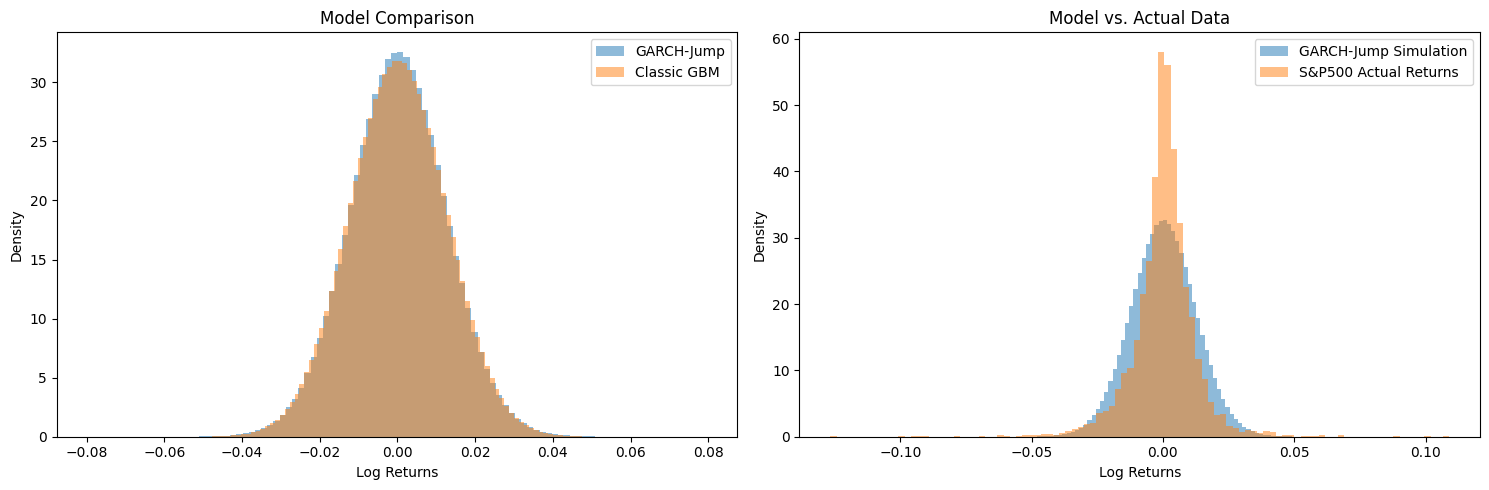

In [136]:
import scipy

# General parameters
num_paths = 20000
S0 = 100                        
mu = np.mean(sp500_log_ret) * 252  # Annualized mean return                     
T = 1.0                         
dt = 1/252                      

# Classic GBM parameters
sigma_constant = np.std(sp500_log_ret) * np.sqrt(252)  # Annualized volatility      

# GARCH-Jump model parameters
kappa_garch = kappa         
sigma_bar_garch = sigma_bar     
alpha_garch = alpha     
lambda_j_garch = lambda_j
mu_j_garch = mu_j
sigma_j_garch = sigma_j

# For initial volatility, use the long-term volatility
sigma0 = sigma_bar_garch

# Monte Carlo simulations
log_returns_constant = monte_carlo_simulation(S0, mu, sigma_constant, T, dt, 
                                           num_paths, 'classic_gbm')
log_returns_garch = monte_carlo_simulation(S0, mu, sigma0, T, dt, num_paths, 
                                         'garch_jump',
                                         sigma0=sigma0,
                                         kappa=kappa_garch,
                                         sigma_bar=sigma_bar_garch,
                                         alpha=alpha_garch,
                                         lambda_j=lambda_j_garch,
                                         mu_j=mu_j_garch,
                                         sigma_j=sigma_j_garch)

# Print summary statistics
print("\nSummary Statistics:")
print("GBM returns range:", np.min(log_returns_constant), np.max(log_returns_constant))
print("GARCH-Jump returns range:", np.min(log_returns_garch), np.max(log_returns_garch))
print("\nActual Data Statistics:")
print("Mean:", np.mean(sp500_log_ret))
print("Std:", np.std(sp500_log_ret))
print("Skew:", scipy.stats.skew(sp500_log_ret))
print("Kurt:", scipy.stats.kurtosis(sp500_log_ret))
print("\nGBM Simulation Statistics:")
print("Mean:", np.mean(log_returns_constant))
print("Std:", np.std(log_returns_constant))
print("Skew:", scipy.stats.skew(log_returns_constant.flatten()))
print("Kurt:", scipy.stats.kurtosis(log_returns_constant.flatten()))
print("\nGARCH-Jump Simulation Statistics:")
print("Mean:", np.mean(log_returns_garch))
print("Std:", np.std(log_returns_garch))
print("Skew:", scipy.stats.skew(log_returns_garch.flatten()))
print("Kurt:", scipy.stats.kurtosis(log_returns_garch.flatten()))

# Plot distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Compare models
ax1.hist(log_returns_garch.flatten(), bins=100, alpha=0.5, 
         label='GARCH-Jump', density=True)
ax1.hist(log_returns_constant.flatten(), bins=100, alpha=0.5, 
         label='Classic GBM', density=True)
ax1.set_title('Model Comparison')
ax1.set_xlabel('Log Returns')
ax1.set_ylabel('Density')
ax1.legend()

# Compare with actual data
ax2.hist(log_returns_garch.flatten(), bins=100, alpha=0.5, 
         label='GARCH-Jump Simulation', density=True)
ax2.hist(sp500_log_ret, bins=100, alpha=0.5, 
         label='S&P500 Actual Returns', density=True)
ax2.set_title('Model vs. Actual Data')
ax2.set_xlabel('Log Returns')
ax2.set_ylabel('Density')
ax2.legend()

plt.tight_layout()
plt.show()

In [13]:
import numpy as np
from scipy import stats
from math import log, sqrt, exp

def d1(S0, K, T, r, sigma, q=0):
    if T == 0:
        return float('inf') if S0 > K else float('-inf') if S0 < K else 0.0
    return (log(S0 / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))

def d2(S0, K, T, r, sigma, q=0):
    return d1(S0, K, T, r, sigma, q) - sigma * sqrt(T) if T != 0 else 0

def delta(S0, K, T, r, sigma, option_type, q=0):
    d1_val = d1(S0, K, T, r, sigma, q)
    if option_type == 'call':
        return stats.norm.cdf(d1_val)
    elif option_type == 'put':
        return stats.norm.cdf(d1_val) - 1

def price(S0, K, T, r, sigma, option_type, q=0):
    if option_type not in ['call', 'put']:
        raise ValueError("option_type must be 'call' or 'put'")
    if sigma <= 0 or T < 0 or K <= 0 or S0 <= 0:
        raise ValueError("Invalid parameters")
    d1_val = d1(S0, K, T, r, sigma, q)
    d2_val = d2(S0, K, T, r, sigma, q)
    if option_type == 'call':
        return S0 * exp(-q * T) * stats.norm.cdf(d1_val) - K * exp(-r * T) * stats.norm.cdf(d2_val)
    elif option_type == 'put':
        return K * exp(-r * T) * stats.norm.cdf(-d2_val) - S0 * exp(-q * T) * stats.norm.cdf(-d1_val)

def garch_volatility(N, sigma0, kappa, sigma_bar, alpha, z):
    """ Generate GARCH(1,1) volatility path using N+1 points including the starting point. """
    sigma2 = np.zeros(N+1)
    sigma2[0] = sigma0**2

    for i in range(1, N+1):
        sigma2[i] = kappa * sigma_bar**2 + (1 - kappa - alpha) * sigma2[i-1] + alpha * z[i-1]**2 * sigma2[i-1]

    return np.sqrt(sigma2)
    
def GARCH_with_jumps(S0, mu, sigma0, kappa, sigma_bar, alpha, T, dt, jump_intensity, jump_mean, jump_std):
    """
    Simulates a GARCH(1,1) model with random jumps.

    Parameters:
    - S0: float, Initial stock price.
    - mu: float, Drift term.
    - sigma0: float, Initial volatility.
    - kappa: float, GARCH mean reversion speed.
    - sigma_bar: float, Long-term average volatility.
    - alpha: float, GARCH shock parameter.
    - T: float, Total simulation time.
    - dt: float, Time step.
    - jump_intensity: float, Poisson intensity for jump occurrences (λ).
    - jump_mean: float, Mean of jump magnitudes (log-normal parameter).
    - jump_std: float, Standard deviation of jump magnitudes (log-normal parameter).

    Returns:
    - S: np.ndarray, Simulated stock prices.
    - t: np.ndarray, Time points.
    - sigma_t: np.ndarray, GARCH volatility path.
    """
    N = int(T / dt)
    t = np.linspace(0, T, N + 1)
    S = np.zeros(N + 1)
    S[0] = S0

    # GARCH volatility
    z = np.random.normal(0, 1, N)
    sigma_t = garch_volatility(N, sigma0, kappa, sigma_bar, alpha, z)

    # Brownian motion increments
    dW = np.random.normal(0, np.sqrt(dt), N)

    # Jump process
    jump_occurrences = np.random.poisson(jump_intensity * dt, N)  # Poisson process for jumps
    jump_magnitudes = np.random.normal(jump_mean, jump_std, size=N)  # Jump sizes
    J = jump_occurrences * jump_magnitudes

    # Simulate price path
    for i in range(1, N + 1):
        drift = (mu - 0.5 * sigma_t[i - 1]**2) * dt
        diffusion = sigma_t[i - 1] * dW[i - 1]
        jump = J[i - 1]
        S[i] = S[i - 1] * np.exp(drift + diffusion + jump)

    return S, t, sigma_t

def portfolio_path_garch(S0, T, r, mu, dt, positions, 
                        sigma0_garch, kappa, sigma_bar, alpha, jump_intensity, jump_mean, jump_std, strikes=None):
    """
    Simulates portfolio values and positions for stock, call, put, and cash securities using GARCH_with_jumps.

    Parameters:
        S0 (float): Initial stock price.
        T (float): Total time to maturity.
        r (float): Risk-free rate.
        mu (float): Drift of the stock.
        dt (float): Time step size.
        positions (dict): Dictionary of positions, e.g., 
                          {'positions': [0, 1, -1, 100], 'security': ['stock', 'call', 'put', 'cash']}.
        sigma0_garch, kappa, sigma_bar, alpha: GARCH parameters.
        jump_intensity, jump_mean, jump_std: Jump parameters for the GARCH model.
        strikes (list): Strike prices for the options, must correspond to positions in the 'call' and 'put' entries.

    Returns:
        dict: Contains arrays for values of each security and total portfolio value over time.
    """
    # Generate the GARCH_with_jumps price path
    S, t, sigma_t = GARCH_with_jumps(S0, mu, sigma0_garch, kappa, sigma_bar, alpha, T, dt, 
                                     jump_intensity, jump_mean, jump_std)

    # Extract position information
    positions_array = positions['positions']
    security_array = positions['security']
    if strikes is None:
        strikes = [S0] * len(positions_array)  # Default to initial stock price for all options
    
    num_steps = len(S)

    # Initialize arrays for each security's value over time
    stock_values = np.zeros(num_steps)
    call_values = np.zeros(num_steps)
    put_values = np.zeros(num_steps)
    cash_values = np.zeros(num_steps)

    # Calculate initial cash adjustment using the same volatility calculation method as the rest of the portfolio
    initial_cash_adjustment = 0
    for i, security in enumerate(security_array):
        if security in ['call', 'put']:
            strike = strikes[i]
            time_to_maturity = T - t[0]
            d1 = (np.log(S[0] / strike) + (r + 0.5 * sigma_t[0] ** 2) * time_to_maturity) / (sigma_t[0] * np.sqrt(time_to_maturity))
            d2 = d1 - sigma_t[0] * np.sqrt(time_to_maturity)
            option_price = (S[0] * stats.norm.cdf(d1) - strike * np.exp(-r * time_to_maturity) * stats.norm.cdf(d2)) if security == 'call' else \
                           (strike * np.exp(-r * time_to_maturity) * stats.norm.cdf(-d2) - S[0] * stats.norm.cdf(-d1))
            initial_cash_adjustment -= positions_array[i] * option_price
        elif security == 'stock':
            initial_cash_adjustment -= positions_array[i] * S[0]
    cash_values[0] = positions_array[-1] + initial_cash_adjustment  # Adjust initial cash


    # Iterate through the time steps and calculate values
    for i, security in enumerate(security_array):
        position = positions_array[i]
        strike = strikes[i] if security in ['call', 'put'] else None

        if security == 'stock':
            stock_values = position * S

        elif security == 'call':
            # Handle option expiration and edge cases for T-t
            time_to_maturity = np.maximum(T - t, 0)
            d1 = np.where(
                time_to_maturity > 0,
                (np.log(S / strike) + (r + 0.5 * sigma_t ** 2) * time_to_maturity) / (sigma_t * np.sqrt(time_to_maturity)),
                np.where(S > strike, float('inf'), float('-inf'))
            )
            d2 = np.where(time_to_maturity > 0, d1 - sigma_t * np.sqrt(time_to_maturity), np.where(S > strike, float('inf'), float('-inf')))
            call_values = position * np.where(
                time_to_maturity > 0,
                S * stats.norm.cdf(d1) - strike * np.exp(-r * time_to_maturity) * stats.norm.cdf(d2),
                np.maximum(S - strike, 0)  # Payoff at expiration
            )

        elif security == 'put':
            # Handle option expiration and edge cases for T-t
            time_to_maturity = np.maximum(T - t, 0)
            d1 = np.where(
                time_to_maturity > 0,
                (np.log(S / strike) + (r + 0.5 * sigma_t ** 2) * time_to_maturity) / (sigma_t * np.sqrt(time_to_maturity)),
                np.where(S < strike, float('inf'), float('-inf'))
            )
            d2 = np.where(time_to_maturity > 0, d1 - sigma_t * np.sqrt(time_to_maturity), np.where(S < strike, float('inf'), float('-inf')))
            put_values = position * np.where(
                time_to_maturity > 0,
                strike * np.exp(-r * time_to_maturity) * stats.norm.cdf(-d2) - S * stats.norm.cdf(-d1),
                np.maximum(strike - S, 0)  # Payoff at expiration
            )

        elif security == 'cash':
            cash_values = position * np.exp(r * t)

    # Calculate total portfolio value at each time step
    total_values = stock_values + call_values + put_values + cash_values

    # Return results as a dictionary
    return {
        'stock_values': stock_values,
        'call_values': call_values,
        'put_values': put_values,
        'cash_values': cash_values,
        'total_values': total_values,
        'sigma_t': sigma_t,
        'stock_path': S
    }

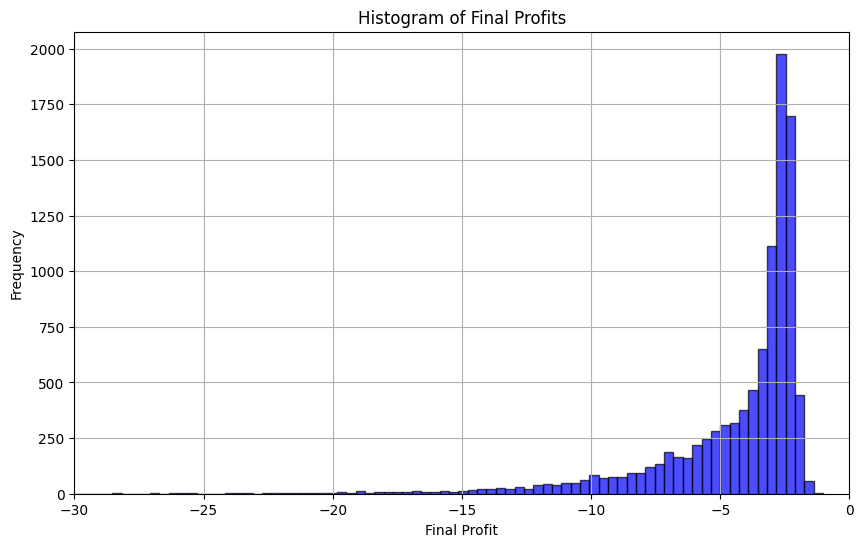

In [61]:
def dh_path(S0, K, T, r, option_type, mu, dt, option_pos, sigma0_garch, kappa, sigma_bar, alpha, jump_intensity, jump_mean, jump_std):

    S, t, sigma_t = GARCH_with_jumps(S0, mu, sigma0_garch, kappa, sigma_bar, alpha, T, dt, 
                                     jump_intensity, jump_mean, jump_std)
    option_price = price(S0, K, T, r, sigma_t[0], option_type)
    N = len(S)
    T_i = T - t

    d1_vals = np.where(
        T_i[:-1] == 0,
        np.where(S[:-1] > K, float('inf'), np.where(S[:-1] < K, float('-inf'), 0.0)),
        (np.log(S[:-1] / K) + (r + 0.5 * sigma_t[:-1] ** 2) * T_i[:-1]) / (sigma_t[:-1] * np.sqrt(T_i[:-1]))
    )
    d1_vals = np.append(
        d1_vals, 
        float('inf') if S[-1] > K else float('-inf') if S[-1] < K else 0.0
    )

    delta_vals = stats.norm.cdf(d1_vals) if option_type == 'call' else stats.norm.cdf(d1_vals) - 1

    delta_diff = np.diff(delta_vals, prepend=0)
    cashflows = delta_diff * option_pos * S
    comp_factors = np.exp(r * (T - t)) - 1
    interests = cashflows * comp_factors
    pnl_path = np.cumsum(interests + cashflows)

    if option_type == 'call' and S[-1] > K:
        pnl_path[-1] -= K * option_pos
    elif option_type == 'put' and S[-1] < K:
        pnl_path[-1] += K * option_pos

    # pnl_path -= option_price * option_pos
    pnl_path *= np.exp(-r * T)

    return pnl_path
    # return pd.DataFrame({
    #     'pnl_path': pnl_path,
    #     'stock_price': S,
    #     'time': t,
    #     'volatility': sigma_t,
    #     'delta': delta_vals,
    #     'delta_diff': delta_diff,
    #     'cashflows': cashflows,
    #     'interests': interests
    # })

S0 = 100
mu = 0.08
sigma0_gj = 0.1
kappa = 0.2        # Mean reversion coefficient
sigma_bar = 0.15    # Long term vol
sigma_bar_gj = 0.1
alpha = 0.1        # GARCH reaction coefficient
T = 0.3
dt = 1/252
jump_intensity = 4  # Average of 10 jumps per unit time
jump_mean =  0.0  # Mean jump magnitude (log-normal parameter)
jump_std_g = 0.1      # Std dev of jump magnitude
r = 0.05
K = 100
option_type = 'put'
option_pos = -1
num_paths = 10000

import pandas as pd

final_profits = []
paths = []
for _ in range(num_paths):
    results = dh_path(S0=S0, K=K, T=T, r=r, option_type=option_type, mu=mu, dt=dt, option_pos=option_pos, sigma0_garch=sigma0_gj, alpha=alpha, kappa=kappa, sigma_bar=sigma_bar, jump_intensity=jump_intensity, jump_mean=jump_mean, jump_std=jump_std_g)
    final_profits.append(results[-1])
    paths.append(results)

# Plot histogram of final profits
plt.figure(figsize=(10, 6))
plt.hist(final_profits, bins=100, alpha=0.7, color='blue', edgecolor='black')
plt.xlim(-30, 0)
plt.title("Histogram of Final Profits")
plt.xlabel("Final Profit")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

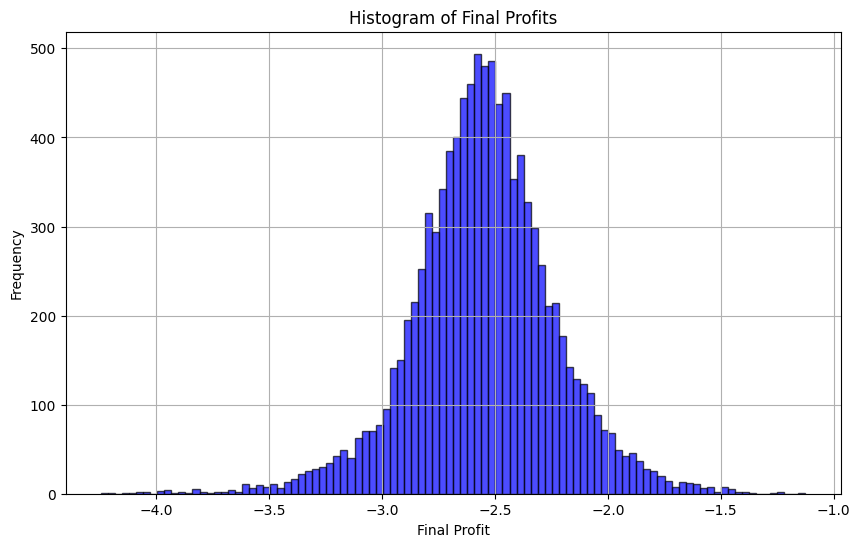

In [62]:
def GBM(S0, mu, sigma, T, dt):
    N = int(T / dt)
    t = np.array([i * dt for i in range(N + 1)])
    W = np.random.normal(0, 1, N)
    W = np.insert(W, 0, 0)
    W = np.cumsum(W) * np.sqrt(dt)
    S = S0 * np.exp((mu - 0.5 * sigma ** 2) * t + sigma * W)
    return S

def dh_path_BSM(S0, K, T, r, sigma, option_type, mu, dt, option_pos, path=None):
    
    S = GBM(S0, mu, sigma, T, dt) if path is None else np.array(path)
    option_price = price(S0, K, T, r, sigma, option_type)
    N = len(S)
    t = np.linspace(0, T, N)
    T_i = T - t

    d1_vals = np.where(
        T_i[:-1] == 0,
        np.where(S[:-1] > K, float('inf'), np.where(S[:-1] < K, float('-inf'), 0.0)),
        (np.log(S[:-1] / K) + (r + 0.5 * sigma ** 2) * T_i[:-1]) / (sigma * np.sqrt(T_i[:-1]))
    )
    d1_vals = np.append(
        d1_vals, 
        float('inf') if S[-1] > K else float('-inf') if S[-1] < K else 0.0
    )

    delta_vals = stats.norm.cdf(d1_vals) if option_type == 'call' else stats.norm.cdf(d1_vals) - 1

    delta_diff = np.diff(delta_vals, prepend=0)
    cashflows = delta_diff * option_pos * S
    comp_factors = np.exp(r * (T - t)) - 1
    interests = cashflows * comp_factors
    pnl_path = np.cumsum(interests + cashflows)

    if option_type == 'call' and S[-1] > K:
        pnl_path[-1] -= K * option_pos
    elif option_type == 'put' and S[-1] < K:
        pnl_path[-1] += K * option_pos

    # pnl_path -= option_price * option_pos
    pnl_path *= np.exp(-r * T)

    return pnl_path

S0 = 100
mu = 0.08
sigma0_gj = 0.1
kappa = 0.2        # Mean reversion coefficient
sigma_bar = 0.15    # Long term vol
sigma_bar_gj = 0.1
alpha = 0.1        # GARCH reaction coefficient
T = 0.3
dt = 1/252
jump_intensity = 4  # Average of 10 jumps per unit time
jump_mean =  0.0  # Mean jump magnitude (log-normal parameter)
jump_std_g = 0.1      # Std dev of jump magnitude
r = 0.05
K = 100
option_type = 'put'
option_pos = -1
num_paths = 10000

import pandas as pd

final_profits_2 = []
for _ in range(num_paths):
    results = dh_path_BSM(S0=S0, K=K, T=T, r=r, sigma=sigma_bar, option_type=option_type, mu=mu, dt=dt, option_pos=option_pos)
    final_profits_2.append(results[-1])

# Plot histogram of final profits
plt.figure(figsize=(10, 6))
plt.hist(final_profits_2, bins=100, alpha=0.7, color='blue', edgecolor='black')
plt.title("Histogram of Final Profits")
plt.xlabel("Final Profit")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

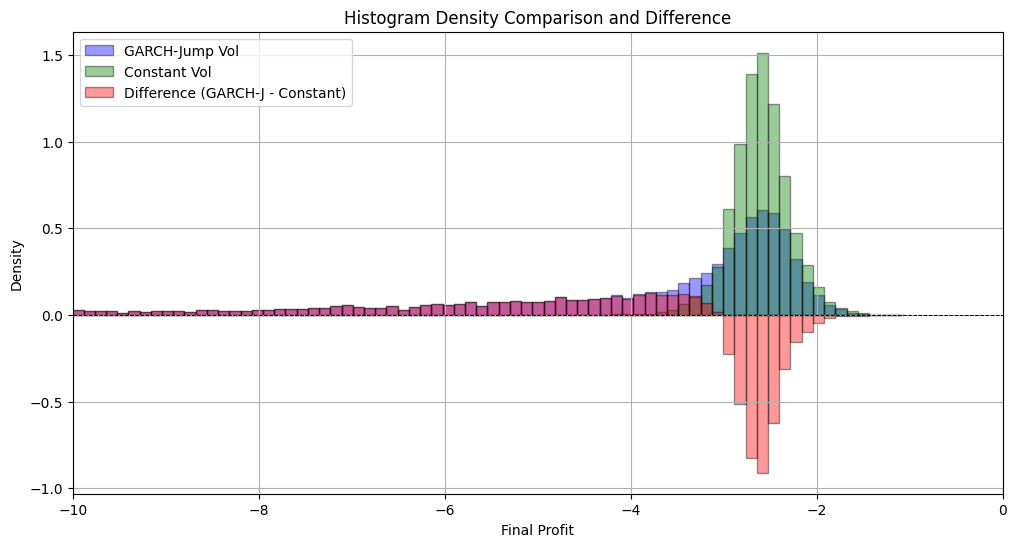

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, normaltest

# Define the range for a shared histogram
combined_min = min(min(final_profits), min(final_profits_2))
combined_max = max(max(final_profits), max(final_profits_2))

# Create bins over the shared range
num_bins = 400  # Adjust as needed
bin_edges = np.linspace(combined_min, combined_max, num_bins + 1)

# Compute histograms (normalized to densities)
hist1, _ = np.histogram(final_profits, bins=bin_edges, density=True)
hist2, _ = np.histogram(final_profits_2, bins=bin_edges, density=True)

# Calculate the density difference
density_diff = hist1 - hist2

# Plot the histograms
plt.figure(figsize=(12, 7))

# Plot the histogram for Simulation 1
plt.bar(bin_edges[:-1], hist1, width=np.diff(bin_edges), alpha=0.4, label="GARCH-Jump Vol", color="blue", edgecolor="black")

# Plot the histogram for Simulation 2
plt.bar(bin_edges[:-1], hist2, width=np.diff(bin_edges), alpha=0.4, label="Constant Vol", color="green", edgecolor="black")

# Plot the difference as bars
plt.bar(bin_edges[:-1], density_diff, width=np.diff(bin_edges), alpha=0.4, label="Difference (GARCH-J - Constant)", color="red", edgecolor="black")

# Add labels and legend
plt.axhline(0, color="black", linestyle="--", linewidth=0.7)
plt.xlim(-10, 0)
plt.title("Histogram Density Comparison and Difference")
plt.xlabel("Final Profit")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

# Summary statistics function
def compute_summary_statistics(data):
    statistics = {
        "Mean": np.mean(data),
        "Standard Deviation": np.std(data),
        "Skewness": skew(data),
        "Kurtosis": kurtosis(data),
    }
    return statistics

# Compute statistics for both simulations
stats_simulation_1 = compute_summary_statistics(final_profits)
stats_simulation_2 = compute_summary_statistics(final_profits_2)

# Combine and display the results
summary_stats = pd.DataFrame({
    "GARCH-Jump Simulation": stats_simulation_1,
    "Constant Vol Simulation": stats_simulation_2
})

print("Summary Statistics for Simulations:\n")
summary_stats

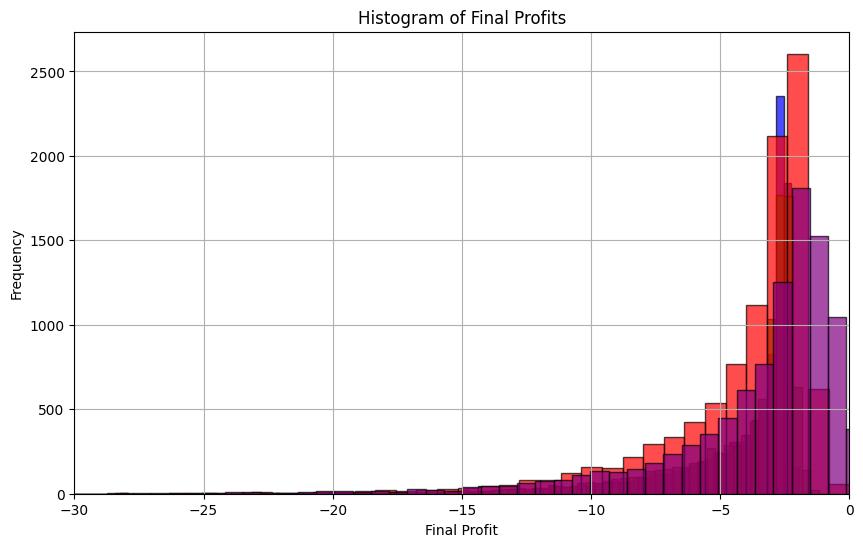

In [ ]:
S0 = 100
mu = 0.08
sigma0_gj = 0.1
kappa = 0.2        # Mean reversion coefficient
sigma_bar = 0.15    # Long term vol
sigma_bar_gj = 0.1
alpha = 0.1        # GARCH reaction coefficient
T = 0.3
dts = [1/(252*8), 1/252, 1/52, 1/12]
jump_intensity = 4  # Average of 10 jumps per unit time
jump_mean =  0.0  # Mean jump magnitude (log-normal parameter)
jump_std_g = 0.1      # Std dev of jump magnitude
r = 0.05
K = 100
option_type = 'put'
option_pos = -1
num_paths = 10000

import pandas as pd

final_prof_dt = []
for dt in dts:
    final_profits = []
    for _ in range(num_paths):
        results = dh_path(S0=S0, K=K, T=T, r=r, option_type=option_type, mu=mu, dt=dt, option_pos=option_pos, sigma0_garch=sigma0_gj, alpha=alpha, kappa=kappa, sigma_bar=sigma_bar, jump_intensity=jump_intensity, jump_mean=jump_mean, jump_std=jump_std_g)
        final_profits.append(results[-1])
    final_prof_dt.append(final_profits)

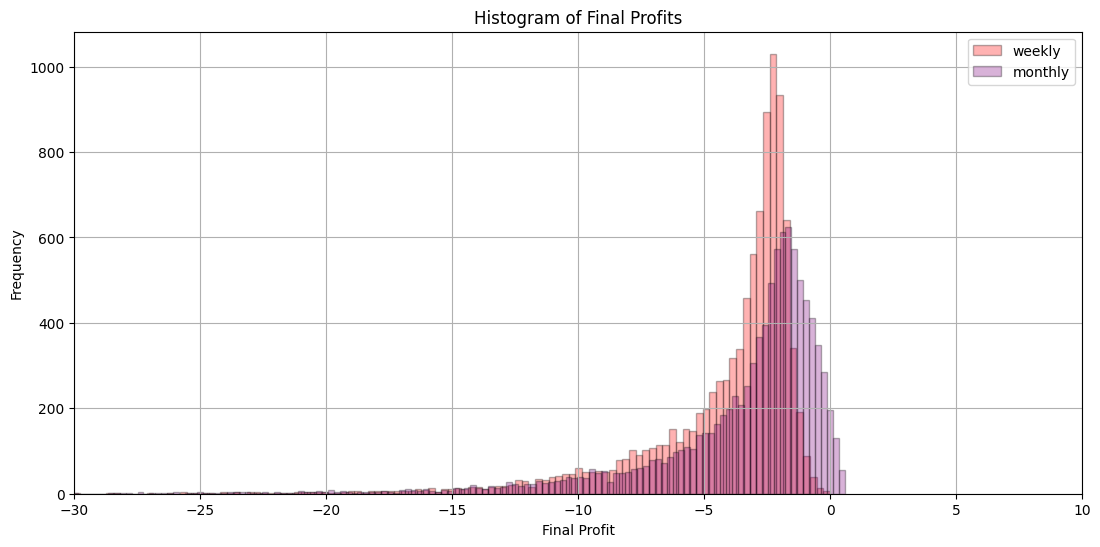

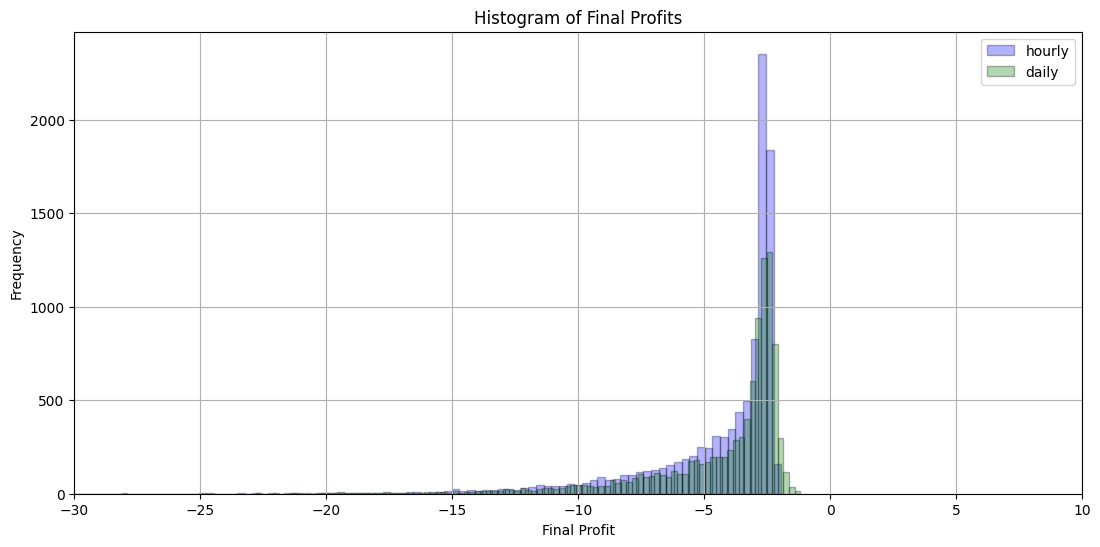

In [85]:
# Plot histogram of final profits
plt.figure(figsize=(13, 6))
plt.hist(final_prof_dt[2], bins=300, alpha=0.3, color='red', edgecolor='black', label='weekly')
plt.hist(final_prof_dt[3], bins=300, alpha=0.3, color='purple', edgecolor='black', label='monthly')
plt.xlim(-30, 10)
plt.title("Histogram of Final Profits")
plt.xlabel("Final Profit")
plt.ylabel("Frequency")
plt.grid(True)
plt.legend()
plt.show()

# Plot histogram of final profits
plt.figure(figsize=(13, 6))
plt.hist(final_prof_dt[0], bins=100, alpha=0.3, color='blue', edgecolor='black', label='hourly')
plt.hist(final_prof_dt[1], bins=150, alpha=0.3, color='green', edgecolor='black', label='daily')
plt.xlim(-30, 10)
plt.title("Histogram of Final Profits")
plt.xlabel("Final Profit")
plt.ylabel("Frequency")
plt.grid(True)
plt.legend()
plt.show()

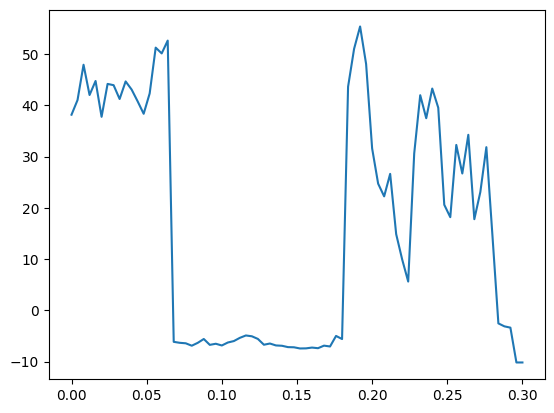

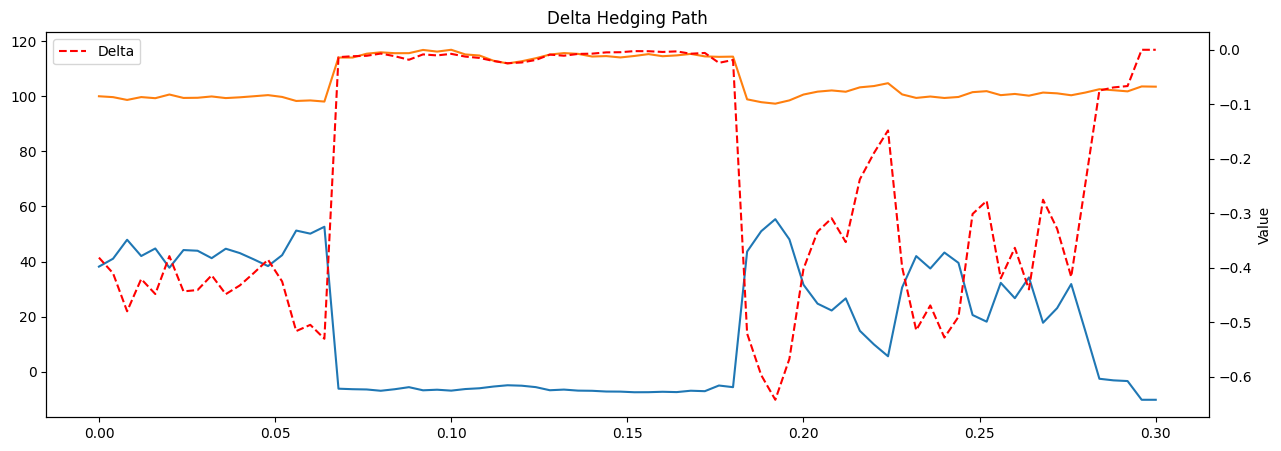

In [53]:

results = dh_path(S0=S0, K=K, T=T, r=r, option_type=option_type, mu=mu, dt=dt, option_pos=option_pos, sigma0_garch=sigma0_gj, alpha=alpha, kappa=kappa, sigma_bar=sigma_bar, jump_intensity=jump_intensity, jump_mean=jump_mean, jump_std=jump_std_g)

plt.plot(results['time'], results['pnl_path'], label='PnL Path')

plt.figure(figsize=(15, 5))
plt.plot(results['time'], results['pnl_path'], label='PnL Path')
plt.plot(results['time'], results['stock_price'], label='Stock Price')
ax2 = plt.twinx()
ax2.plot(results['time'], results['delta'], 'r--', label='Delta')
plt.title('Delta Hedging Path')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [55]:
results['volatility'].mean()

0.15140014831385756

In [9]:
print(f"Final Put Option Value: {results['put_values'][-1]:.2f}")
print(f"Final Call Option Value: {results['call_values'][-1]:.2f}")
print(f"Final Stock Value: {results['stock_values'][-1]:.2f}")
print(f"Final Cash Value: {results['cash_values'][-1]:.2f}")
print(f"Final Total Portfolio Value: {results['total_values'][-1]:.2f}")
print(f"Final Volatility: {results['sigma_t'][-1]:.4f}")
print(f"Final Stock Price: {results['stock_path'][-1]:.2f}")

Final Put Option Value: -291.78
Final Call Option Value: 0.00
Final Stock Value: 0.00
Final Cash Value: 0.00
Final Total Portfolio Value: -291.78
Final Volatility: 0.1393
Final Stock Price: 70.82


In [10]:
positions, strikes

({'positions': [0, 10, -10, 0], 'security': ['stock', 'call', 'put', 'cash']},
 [None, 100, 100, None])

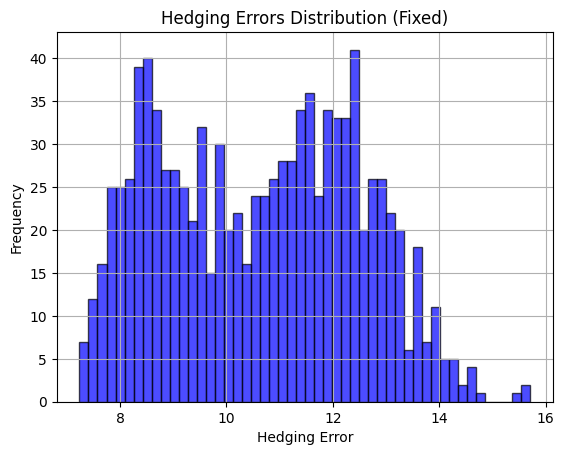

Mean Hedging Error: 10.632359400651653
Standard Deviation of Hedging Error: 1.8540866771504163


In [16]:
def dynamic_hedging_fixed(S0, T, r, dt, option_type, strike, 
                          sigma0_garch, kappa, sigma_bar, alpha, 
                          jump_intensity, jump_mean, jump_std, 
                          num_paths=1000):
    """
    Implements a dynamic delta-hedging strategy with proper initial portfolio setup 
    and fixes for both positive and negative hedging errors.
    
    Parameters:
        S0: Initial stock price.
        T: Total time to maturity.
        r: Risk-free rate.
        dt: Time step size.
        option_type: 'call' or 'put'.
        strike: Strike price of the option.
        sigma0_garch, kappa, sigma_bar, alpha: GARCH parameters.
        jump_intensity, jump_mean, jump_std: Jump parameters.
        num_paths: Number of Monte Carlo paths.
    
    Returns:
        dict: Contains arrays for hedging errors and final portfolio values.
    """
    num_steps = int(T / dt)
    errors = []  # To store hedging errors for all paths
    final_values = []  # To store final portfolio values for all paths
    
    for path in range(num_paths):
        # Generate a stock price path using GARCH with jumps
        S, t, sigma_t = GARCH_with_jumps(S0, r, sigma0_garch, kappa, sigma_bar, alpha, 
                                         T, dt, jump_intensity, jump_mean, jump_std)
        
        # Calculate initial option price
        initial_option_price = price(S0, strike, T, r, sigma_t[0], option_type)
        
        # Set up the initial portfolio
        initial_delta = delta(S0, strike, T, r, sigma_t[0], option_type)
        stock_position = - initial_delta  # Hedge the option delta with stock
        cash_position = initial_option_price - stock_position * S0  # Remaining cash after hedging
        portfolio = stock_position * S0 + cash_position * np.exp(r * dt)  # Total portfolio value

        # Simulate the hedging process over time
        for i in range(1, num_steps):
            time_to_maturity = T - t[i]
            if time_to_maturity <= 0:
                break  # Stop hedging at expiration
            
            # Compute delta and rebalance portfolio
            current_delta = delta(S[i], strike, time_to_maturity, r, sigma_t[i], option_type)
            stock_position = - current_delta
            cash_position = portfolio - stock_position * S[i]
            
            # Update portfolio value for the next step
            portfolio = stock_position * S[i] + cash_position * np.exp(r * dt)
        
        # Compute the final hedging error with complete portfolio valuation
        final_stock_value = stock_position * S[-1]  # Value of stock position at expiration
        
        # Option payoff at expiration
        option_payoff = max(S[-1] - strike, 0) if option_type == 'call' else max(strike - S[-1], 0)
        
        # Adjust stock position value based on option moneyness
        if (option_type == 'call' and S[-1] > strike) or (option_type == 'put' and S[-1] < strike):
            # Option is in the money, stock hedge needs to be adjusted
            final_stock_value += stock_position * strike  # Close out the stock position at strike
        
        # Final hedging error calculation
        hedging_error = final_stock_value + cash_position * np.exp(r * T) - option_payoff
        
        errors.append(hedging_error)
        final_values.append(portfolio)
    
    # Return results
    return {
        'errors': np.array(errors),
        'final_values': np.array(final_values)
    }

# Example usage
results = dynamic_hedging_fixed(S0=100, T=1, r=0.05, dt=1/252, option_type='call', strike=100,
                                sigma0_garch=0.1, kappa=0.2, sigma_bar=0.15, alpha=0.1,
                                jump_intensity=4, jump_mean=0.0, jump_std=0.1, num_paths=1000)

# Analyze results
import matplotlib.pyplot as plt

# Plot the distribution of hedging errors
plt.hist(results['final_values'], bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title("Hedging Errors Distribution (Fixed)")
plt.xlabel("Hedging Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Display summary statistics
import numpy as np
mean_error = np.mean(results['final_values'])
std_error = np.std(results['final_values'])
print(f"Mean Hedging Error: {mean_error}")
print(f"Standard Deviation of Hedging Error: {std_error}")
